In [1]:

import pandas as pd
import os 
import matplotlib.pyplot as plt
import cv2
import albumentations as albu
from albumentations.core.transforms_interface import DualTransform, to_tuple
from PIL import Image
import numpy as np

os.chdir('../../')

In [2]:
meta_df = pd.read_csv('./data/train_df.csv', index_col= 0)



- `ShiftScaleRotate` does not actually change shape of its Image.
    - this brings blank when image is smaller than 512 x 512

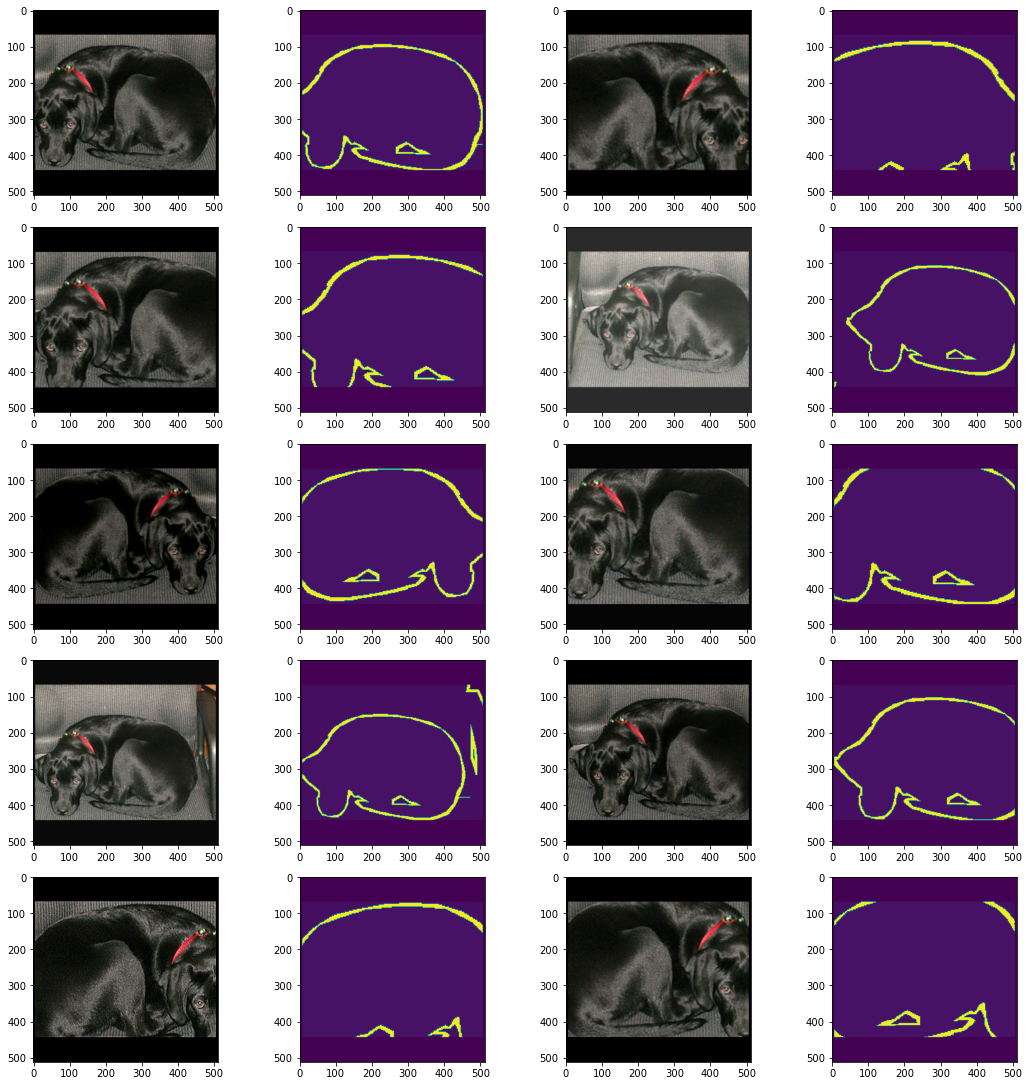

In [3]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=(0.5, 2.0), rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        
        albu.PadIfNeeded(min_height=512, min_width=512,
                         always_apply=True, border_mode=0,
                         mask_value=0),

        albu.RandomBrightnessContrast(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.GaussNoise(p=0.2),        
                albu.RandomGamma(p=1),
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)

sample_image_loc = meta_df.iloc[2]['image_loc']
sample_mask_loc = meta_df.iloc[2]['mask_loc']
sample_image = np.array(Image.open(sample_image_loc))
sample_mask = np.array(Image.open(sample_mask_loc))

fig = plt.figure(figsize=(15, 30))

for i in range(10):  

    sample = get_training_augmentation()(image = sample_image, mask = sample_mask)
    ax = fig.add_subplot(10, 4, 2*(i) + 1)
    ax.imshow(sample['image'])
    # ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(10, 4, 2*(i) + 2)
    ax.imshow(sample['mask'])
    # ax.set_xticks([]); ax.set_yticks([])
    
plt.tight_layout()

In [4]:
import random
class RandomScale(DualTransform):
    def __init__(self, scale_limit=0.1, interpolation=cv2.INTER_LINEAR, always_apply=False, p=0.5):
        super(RandomScale, self).__init__(always_apply, p)
        self.scale_limit = to_tuple(scale_limit, bias=-1.0)
        self.interpolation = interpolation

    def get_params(self):
        return {"scale": random.uniform(self.scale_limit[0], self.scale_limit[1])}

    def apply(self, img, scale=0, interpolation=cv2.INTER_LINEAR, **params):
        h, w = img.shape[:2]
        new_h = int((1+scale) * h)
        new_w = int((1+scale) * w)
        return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    def apply_to_mask(self, img, scale=0, interpolation=cv2.INTER_NEAREST, **params):
        h, w = img.shape[:2]
        new_h = int((1+scale) * h)
        new_w = int((1+scale) * w)        
        return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_NEAREST)


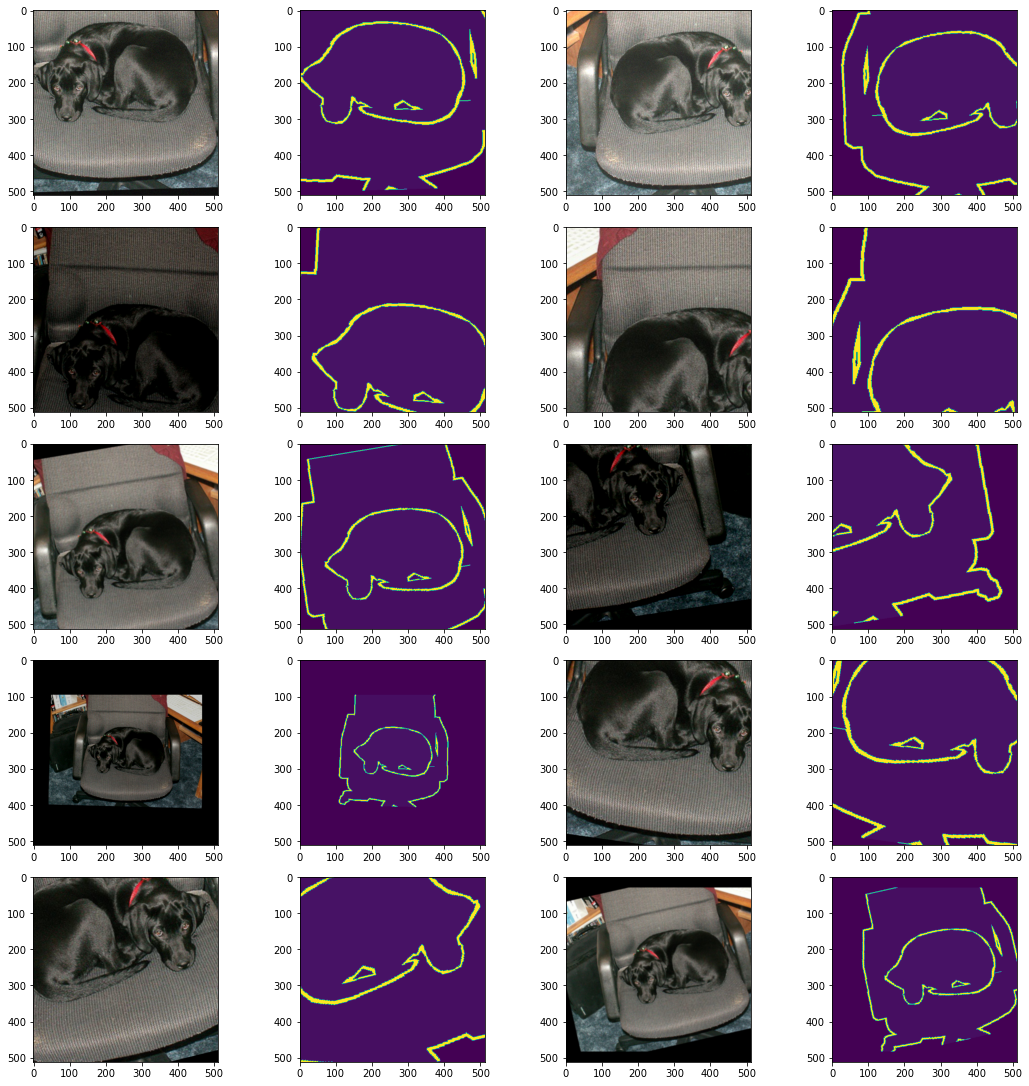

In [5]:
def get_training_augmentation(scale_limit=(0.7,2.5)):
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        RandomScale(scale_limit=scale_limit, p=1),
        albu.ShiftScaleRotate(scale_limit=0., rotate_limit=15, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=512, min_width=512,
                        always_apply=True, border_mode=0,
                        mask_value=0),
        albu.RandomCrop(512, 512, p=1),
        albu.RandomBrightnessContrast(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.GaussNoise(p=1),        
                albu.RandomGamma(p=1),
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)

fig = plt.figure(figsize=(15, 30))
for i in range(10):  
    sample = get_training_augmentation(scale_limit=(0.7,2.5))(image = sample_image, mask = sample_mask)
    ax = fig.add_subplot(10, 4, 2*(i) + 1)
    ax.imshow(sample['image'])
    # ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(10, 4, 2*(i) + 2)
    ax.imshow(sample['mask'])
    # ax.set_xticks([]); ax.set_yticks([])
    
plt.tight_layout()

# Copy blob Augmentation
- Ref: https://github.com/hoya012/semantic-segmentation-tutorial-pytorch/blob/master/learning/utils.py#L246

In [6]:
from src.utils.util import get_labedict
from src.utils.util import color_mask, get_num2color

labeldict = get_labedict()
label2num = labeldict['label2num']
num2label = labeldict['num2label']

cnt_df = pd.read_csv('./data/imbalance_df.csv', index_col=0)
display(cnt_df)

upsample_dict = dict(cnt_df[cnt_df['after'] < 60]['after'].apply(lambda x: int(100/x) ))
upsample_list = []
for label, num in upsample_dict.items():
    upsample_list += [label]*num

print(upsample_list)


before  after
aeroplane        88     18
bicycle          65     13
bird            105     21
boat             78     75
bottle           87     14
bus              78     76
car             128    110
cat             131     25
chair           148     26
cow              64     63
diningtable      82     36
dog             121    110
horse            68     67
motorbike        81     80
person          442    328
pottedplant      82     57
sheep            63     59
sofa             93     53
train            83     83
tvmonitor        83     52
background     1460    992
border         1464    993

['aeroplane', 'aeroplane', 'aeroplane', 'aeroplane', 'aeroplane', 'bicycle', 'bicycle', 'bicycle', 'bicycle', 'bicycle', 'bicycle', 'bicycle', 'bird', 'bird', 'bird', 'bird', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'cat', 'cat', 'cat', 'cat', 'chair', 'chair', 'chair', 'diningtable', 'diningtable', 'pottedplant', 'sheep', 'sofa', 'tvmonitor']


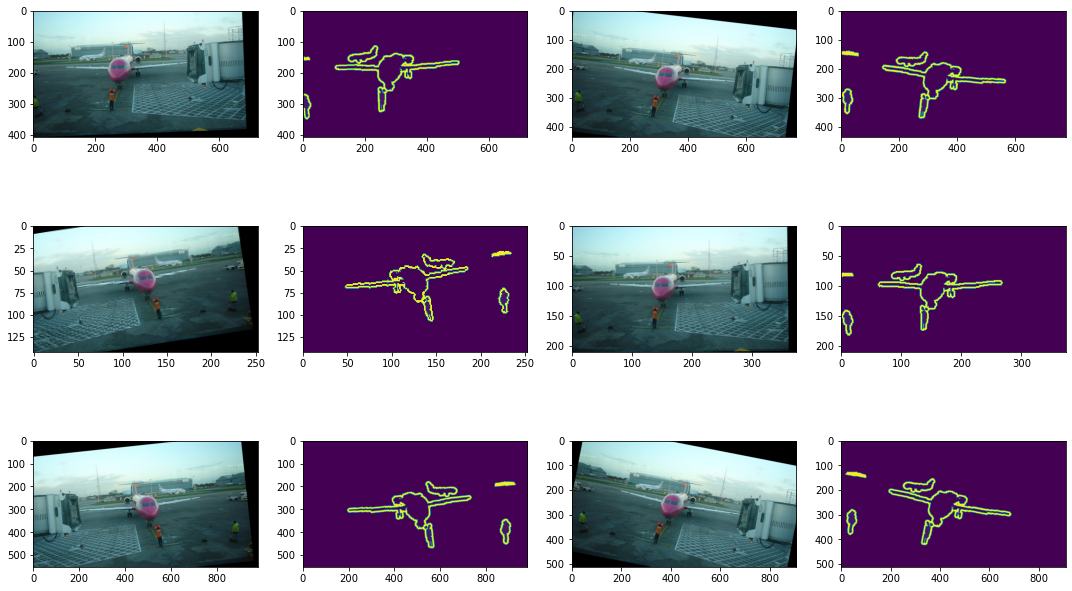

In [7]:
def get_preaug():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        RandomScale(scale_limit=(0.5,2.0), p=1),
        albu.ShiftScaleRotate(scale_limit=0., rotate_limit=20, p=1, border_mode=0),
    ]
    return albu.Compose(train_transform)


src_img = np.array(Image.open(meta_df.iloc[0]['image_loc']))
src_mask = np.array(Image.open(meta_df.iloc[0]['mask_loc']))

fig = plt.figure(figsize=(15, 30))

for i in range(6):  

    sample = get_preaug()(image = src_img, mask = src_mask)
    ax = fig.add_subplot(10, 4, 2*(i) + 1)
    ax.imshow(sample['image'])
    # ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(10, 4, 2*(i) + 2)
    ax.imshow(sample['mask'])
    # ax.set_xticks([]); ax.set_yticks([])
    
plt.tight_layout()

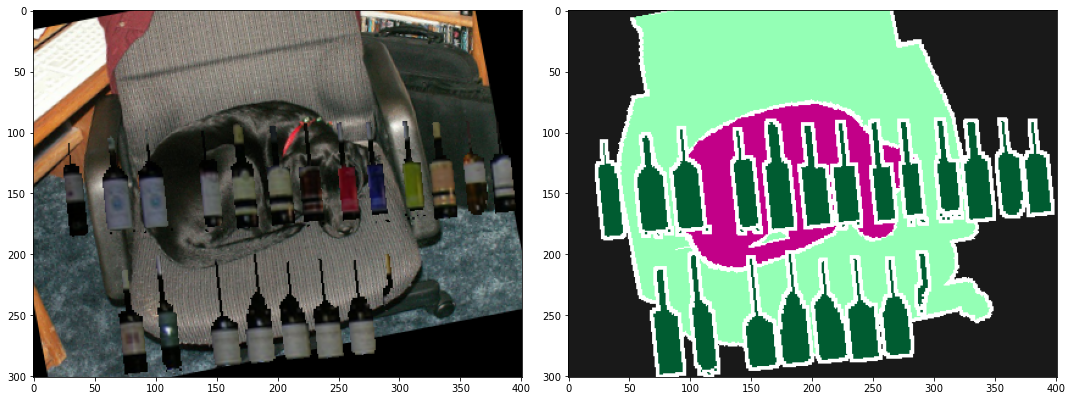

In [8]:
dst_img = np.array(Image.open(sample_image_loc))
dst_mask = np.array(Image.open(sample_mask_loc))

src_label = random.choice(upsample_list)

src_df = meta_df[meta_df[f'{src_label}_cnt'] == True]
src_data_num =  random.randint(0,len(src_df)-1)
src_img = np.array(Image.open(src_df.iloc[src_data_num]['image_loc']))
src_mask = np.array(Image.open(src_df.iloc[src_data_num]['mask_loc']))

src_class = label2num[src_label]
dst_class = label2num['background']

sample_dst = get_preaug()(image=dst_img, mask=dst_mask)
dst_img, dst_mask = sample_dst['image'], sample_dst['mask']

sample_src = get_preaug()(image=src_img, mask=src_mask)
src_img, src_mask = sample_src['image'], sample_src['mask']

src_cnt = np.sum(src_mask==src_class)
dst_cnt = np.sum(dst_mask==dst_class)

if src_cnt != 0 and dst_cnt != 0:
    
    mask_y, mask_x = src_mask.shape
    src_idx = np.where(src_mask==src_class)

    src_idx_sum = list(src_idx[0][i] + src_idx[1][i] for i in range(len(src_idx[0])))
    src_idx_sum_min_idx = np.argmin(src_idx_sum)        
    src_idx_min = src_idx[0][src_idx_sum_min_idx], src_idx[1][src_idx_sum_min_idx]

    dst_idx = np.where(dst_mask==dst_class)
    topleft_idx = np.where((dst_idx[0] <= np.percentile(dst_idx[0], 50)) &
                       (dst_idx[1] <= np.percentile(dst_idx[1], 50)))
    dst_idx = (dst_idx[0][topleft_idx], dst_idx[1][topleft_idx])
    
    rand_idx = np.random.randint(len(dst_idx[0]))
    target_pos = dst_idx[0][rand_idx], dst_idx[1][rand_idx] 

    src_dst_offset = tuple(map(lambda x, y: x - y, src_idx_min, target_pos))
    dst_idx = tuple(map(lambda x, y: x - y, src_idx, src_dst_offset))
    
    avail_idx = np.where((dst_idx[0] < dst_mask.shape[0]) &
                   (dst_idx[1] < dst_mask.shape[1]))
    dst_idx = (dst_idx[0][avail_idx], dst_idx[1][avail_idx])
    src_idx = (src_idx[0][avail_idx], src_idx[1][avail_idx])
    
    dst_mask[dst_idx] = src_class
    dst_img[dst_idx[0], dst_idx[1]] = src_img[src_idx[0], src_idx[1]]
    
    mask_pasted = (dst_mask == src_class).astype(np.uint8)
    mask_pasted_idx = np.where(mask_pasted == 1)
    kernel = np.ones((7,7), np.uint8)
    dilated = cv2.dilate(mask_pasted, kernel, iterations = 1)
    dilated[mask_pasted_idx] = 0
    dilated_idx = np.where(dilated == 1)
    dst_mask[dilated_idx] = 255
    
num2color = get_num2color(num2label)
colored_mask = color_mask(dst_mask, num2color)

fig = plt.figure(figsize=(15, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(dst_img)    
ax = fig.add_subplot(1, 2, 2)
ax.imshow(colored_mask)
plt.tight_layout()




## apply to dataset



In [9]:
from torch.utils.data import Dataset

def get_preaug(scale_limit):
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        RandomScale(scale_limit=scale_limit, p=1),
        albu.ShiftScaleRotate(scale_limit=0., rotate_limit=15, p=1, border_mode=0),
    ]
    return albu.Compose(train_transform)

def get_postaug():
    train_transform = [
        albu.PadIfNeeded(min_height=512, min_width=512,
                                always_apply=True, border_mode=0,
                                mask_value=0),
        albu.RandomCrop(512, 512, p=1),
        albu.RandomBrightnessContrast(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.GaussNoise(p=1),        
                albu.RandomGamma(p=1),
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)

def copyblob(dst_img, dst_mask, meta_df, upsample_list, label2num, get_preaug, get_postaug):
    src_label = random.choice(upsample_list)
    src_df = meta_df[meta_df[f'{src_label}_cnt'] == True]
    src_data_num =  random.randint(0,len(src_df)-1)
    src_img = np.array(Image.open(src_df.iloc[src_data_num]['image_loc']))
    src_mask = np.array(Image.open(src_df.iloc[src_data_num]['mask_loc']))

    src_class = label2num[src_label]
    dst_class = label2num['background']

    sample_dst = get_preaug(scale_limit=(0.8, 2.0))(image=dst_img, mask=dst_mask)
    dst_img, dst_mask = sample_dst['image'], sample_dst['mask']
    
    pre_src_cnt = np.sum(src_mask == src_class) / (src_mask.shape[0] * src_mask.shape[1])
    if pre_src_cnt < 0.1:
        sample_src = get_preaug(scale_limit=(1.0, 2.0))(image=src_img, mask=src_mask)
    else:
        sample_src = get_preaug(scale_limit=(0.5, 1.5))(image=src_img, mask=src_mask)
    
    src_img, src_mask = sample_src['image'], sample_src['mask']
    
    src_cnt = np.sum(src_mask==src_class)
    dst_cnt = np.sum(dst_mask==dst_class)

    if src_cnt != 0 and dst_cnt != 0:
        src_idx = np.where(src_mask==src_class)

        src_idx_sum = list(src_idx[0][i] + src_idx[1][i] for i in range(len(src_idx[0])))
        src_idx_sum_min_idx = np.argmin(src_idx_sum)        
        src_idx_min = src_idx[0][src_idx_sum_min_idx], src_idx[1][src_idx_sum_min_idx]

        dst_idx = np.where(dst_mask==dst_class)
        topleft_idx = np.where((dst_idx[0] <= np.percentile(dst_idx[0], 50)) &
                           (dst_idx[1] <= np.percentile(dst_idx[1], 50)))
        dst_idx = (dst_idx[0][topleft_idx], dst_idx[1][topleft_idx])

        rand_idx = np.random.randint(len(dst_idx[0]))
        target_pos = dst_idx[0][rand_idx], dst_idx[1][rand_idx] 

        src_dst_offset = tuple(map(lambda x, y: x - y, src_idx_min, target_pos))
        dst_idx = tuple(map(lambda x, y: x - y, src_idx, src_dst_offset))

        avail_idx = np.where((dst_idx[0] < dst_mask.shape[0]) &
                             (dst_idx[1] < dst_mask.shape[1]) &
                             (dst_idx[0] >= 0) &
                             (dst_idx[1] >= 0))
        dst_idx = (dst_idx[0][avail_idx], dst_idx[1][avail_idx])
        src_idx = (src_idx[0][avail_idx], src_idx[1][avail_idx])

        dst_mask[dst_idx] = src_class
        dst_img[dst_idx[0], dst_idx[1]] = src_img[src_idx[0], src_idx[1]]

        mask_pasted = (dst_mask == src_class).astype(np.uint8)
        mask_pasted_idx = np.where(mask_pasted == 1)
        kernel = np.ones((7,7), np.uint8)
        dilated = cv2.dilate(mask_pasted, kernel, iterations = 1)
        dilated[mask_pasted_idx] = 0
        dilated_idx = np.where(dilated == 1)
        dst_mask[dilated_idx] = 255
        sample_dst = get_postaug(image=dst_img, mask=dst_mask)
        dst_img, dst_mask = sample_dst['image'], sample_dst['mask']
        return True, dst_img, dst_mask
    else:
        return False, None, None

class VOC_CopyPasteDataset(Dataset):
    def __init__(
            self, 
            meta_df,
            augmentation=None,
            preprocessing=None,
            copypaste_prop = 0.5,
            upsample_list = None,
            pre_aug=None,
            post_aug=None,
            label2num=None
    ):
        self.ids = meta_df['id']
        self.images = meta_df['image_loc']
        self.masks = meta_df['mask_loc']
        self.meta_df = meta_df
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        self.copypaste_prop = copypaste_prop
        self.upsample_list = upsample_list
        self.pre_aug = pre_aug
        self.post_aug = post_aug
        self.label2num = label2num
        
    def __getitem__(self, i):
        # read data
        dst_img = np.array(Image.open(self.images.iloc[i]))
        dst_mask = np.array(Image.open(self.masks.iloc[i]))
        cur_id = self.ids.iloc[i]

        paste_prob = random.random()
        if paste_prob < self.copypaste_prop:
            result, image, mask = copyblob(dst_img, dst_mask, 
                                           self.meta_df, self.upsample_list, 
                                           self.label2num, self.pre_aug, self.post_aug)
            if result:
                dst_img, dst_mask= image, mask
                if self.preprocessing:
                    sample = self.preprocessing(image=dst_img, mask=dst_mask)
                    dst_img, dst_mask = sample['image'], sample['mask']
                return dst_img, dst_mask, cur_id

        if self.augmentation:
            sample = self.augmentation(image=dst_img, mask=dst_mask)
            dst_img, dst_mask = sample['image'], sample['mask']
        if self.preprocessing:
            sample = self.preprocessing(image=dst_img, mask=dst_mask)
            dst_img, dst_mask = sample['image'], sample['mask']
        return dst_img, dst_mask, cur_id

    def __len__(self):
        return len(self.ids)

    
    

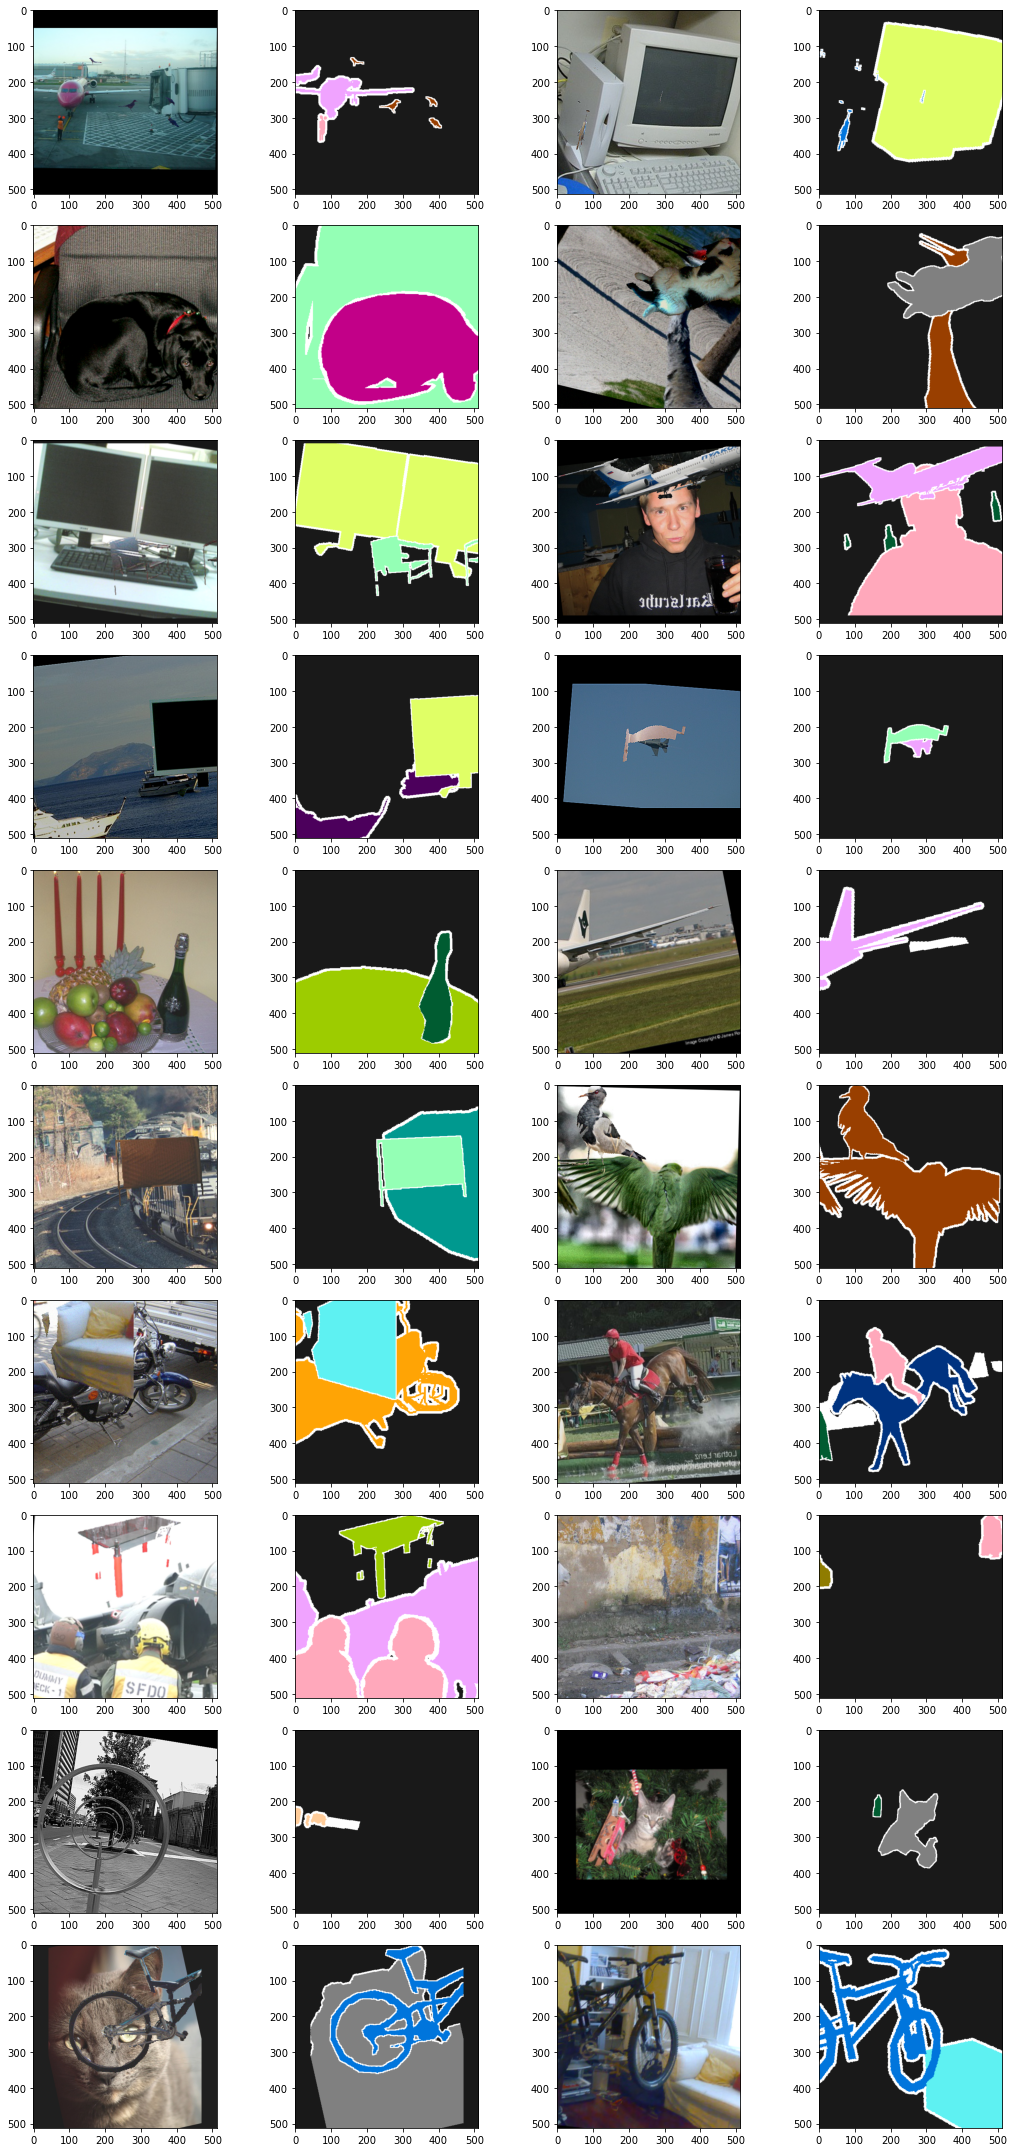

In [10]:
cur_dataset = VOC_CopyPasteDataset(meta_df,
                                    augmentation=get_training_augmentation(),
                                    preprocessing=None,
                                    copypaste_prop = 1,
                                    upsample_list = upsample_list,
                                    pre_aug=get_preaug,
                                    post_aug=get_postaug(),
                                    label2num=label2num)



fig = plt.figure(figsize=(15, 30))
for i in range(20):  
    img, mask, _ = cur_dataset[i]
    ax = fig.add_subplot(10, 4, 2*(i) + 1)
    ax.imshow(img)
    # ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(10, 4, 2*(i) + 2)
    ax.imshow(color_mask(mask, num2color))
    # ax.set_xticks([]); ax.set_yticks([])
    
plt.tight_layout()

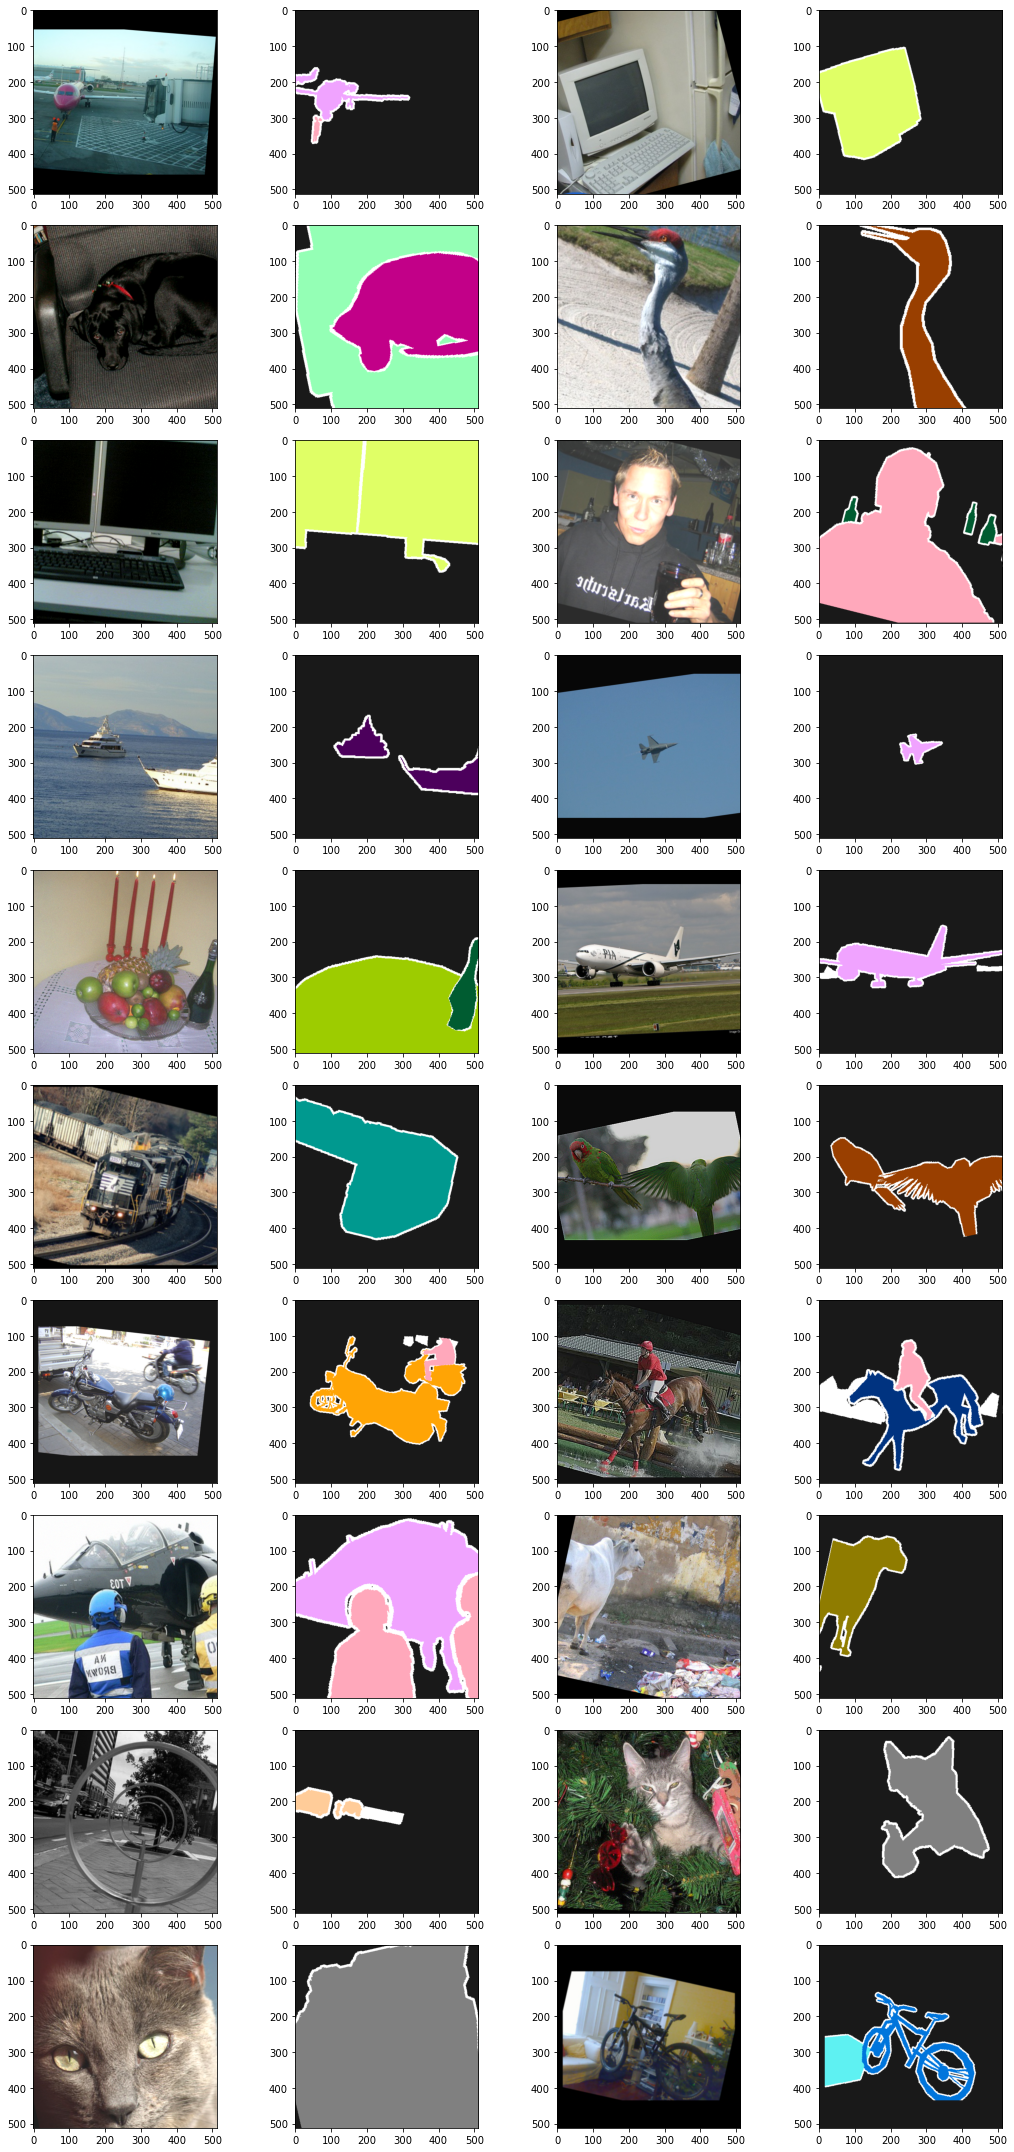

In [11]:

from src.utils.dataset import VOCDataset

cur_dataset = VOCDataset(
    meta_df,
    augmentation=get_training_augmentation(scale_limit=(0.8, 2.0)), 
)

fig = plt.figure(figsize=(15, 30))
for i in range(20):  
    img, mask, _ = cur_dataset[i]
    ax = fig.add_subplot(10, 4, 2*(i) + 1)
    ax.imshow(img)
    # ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(10, 4, 2*(i) + 2)
    ax.imshow(color_mask(mask, num2color))
    # ax.set_xticks([]); ax.set_yticks([])
    
plt.tight_layout()

In [12]:
%%timeit
np.random.random()

199 ns ± 0.661 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [ ]:
%%timeit
random.random()